* Submission by Agrim Gupta, 140020003

# Simulation Settings.
Consider a CDMA cellular system as shown in Figure 1 of the assignment PS. Base Stations (BSs) are located at the center of each hexagonal cell with cell radius of $R_c$ = 500 m. We refer to the cell in the center as the reference cell, which is surrounded by six cells forming the first tier. Each cell has M Mobile Stations (MSs) which are randomly and uniformly distributed. We consider an uplink scenario where every MS transmits a BPSK signal. We assume that there is a tight power control at MSs. Therefore, the power P received from any MS at its serving BS is −60 dBm and the power received at any other BS has a path loss exponent $\gamma$ = 3.5. We also assume an AWGN channel with noise power $N_0$ = −90 dBm. For each MS, a wide band random sequence of length 512 is generated with each component being $\pm 1$ with equal probability. These sequences are assumed to be known to their serving BSs. All plots are done in semilog form.

# Evaluation of BER for a single cell scenario
In this scenario, consider only the reference cell. Increase the number of MSs M in the reference cell and measure average Bit Error Rate (BER) of an MS. Vary the number of MS in steps of 10 upto 100 and plot the variation of M v/s BER for 1000 iterations. Also plot the variation of M v/s Signal to Interference and Noise Ratio (SINR).

## Procedure
* Each M user transmits a 512 bit signal, which is obtained by multiplying the tranmsitted signal by the corresponding pseudorandom(PRN) sequence.
* The BS receives the sum of all such sequences from M users. AWGN noise of length 512 and variance $\frac{Noise Power}{2}$ is added to the received signal.
* To decode the symbol transmitted by a user, inner product of the received sequence with the corresponding PRN is taken. Symbol is decoded by observing the sign of the inner product, since BPSK modulation was done. BER is then obtained by taking a diff. with the expected signal.

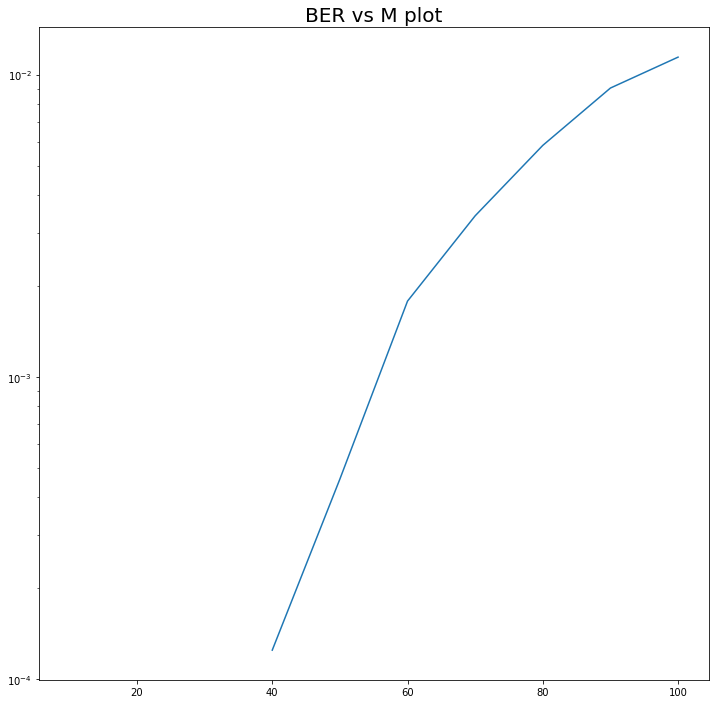

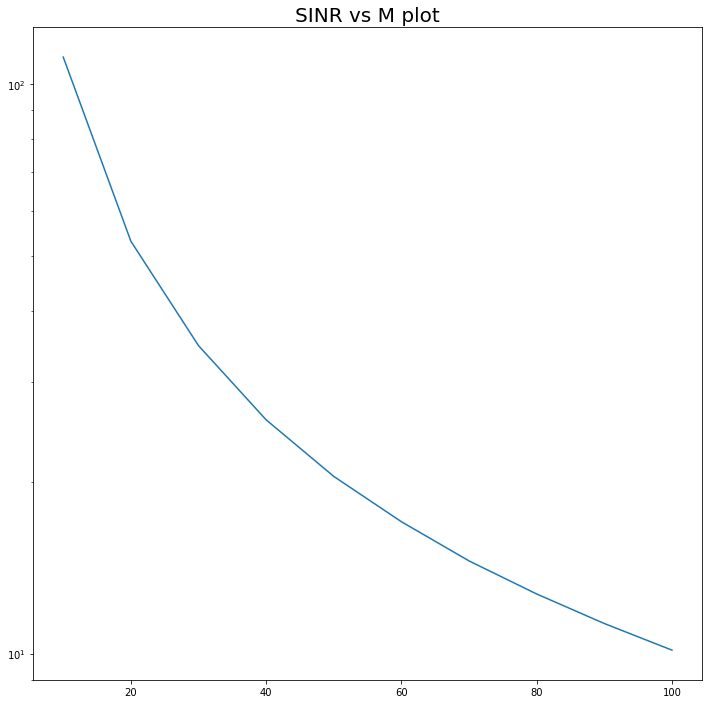

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Function to give BER and SINR for users M in a single cell
def BER_SINR_vs_M_singlecell(M):
    #Typecast
    M=int(M)
    #Convert signal powers to watts
    sig_pow_dbm=-60
    sig_pow=0.001*10**(sig_pow_dbm/10)
    noise_pow_dbm=-90
    noise_pow=0.001*10**(noise_pow_dbm/10)
    
    #Symbols txed by M MS's
    num_syms=1000
    PRN_len=512
    #PRN sequences corresponding to M MS's
    PRN_seq=2*np.random.randint(2,size=(PRN_len,M))-1
    
    BER=np.zeros(M)
    SINR=np.zeros(M)
    for t in range(num_syms):
        sym_gen=2*np.random.randint(2,size=(M))-1
        sig_gen=np.sqrt(sig_pow)*sym_gen
        Noise_sigma_V=np.sqrt(noise_pow/2)
        # Get Noise
        Noise=(np.random.normal(0,Noise_sigma_V,size=(PRN_len)))
        
        diff_sigs=np.multiply(sig_gen,PRN_seq)
        var_user=np.sum(np.square(diff_sigs),axis=0)/512
        sig_rxed=np.sum(diff_sigs,axis=1)+Noise
        var_sig=np.sum(np.square(sig_rxed))/512
        SINR+=[var_user[i]/(var_sig-var_user[i]) for i in range(M)]
        
        #Multiply by PRN seq again
        dePRN_sig=np.matmul(sig_rxed,PRN_seq)
        
        #Decode by decision region
        bins=[0]
        decoded_sig=2*np.digitize(dePRN_sig.real,bins)-1
        
        #BER: *1 to convert bool to int
        BER+=(decoded_sig!=sym_gen)*1
    
    avg_BER=np.sum(BER)/(M*num_syms)
    avg_SINR=np.sum(SINR)/M
    return avg_BER,avg_SINR

plt.rcParams['figure.figsize'] = (12,12)
sim_M=np.linspace(10,100,10)
BER_SINR_vs_M_singlecell=[BER_SINR_vs_M_singlecell(M) for M in sim_M]
BER_vs_M_singlecell=[BER_SINR[0] for BER_SINR in BER_SINR_vs_M_singlecell]
SINR_vs_M_singlecell=[BER_SINR[1] for BER_SINR in BER_SINR_vs_M_singlecell]

plt.title("BER vs M plot",fontsize=20)
plt.semilogy(sim_M,BER_vs_M_singlecell)
plt.show()
plt.title("SINR vs M plot",fontsize=20)
plt.semilogy(sim_M,SINR_vs_M_singlecell)
plt.show()

## Observations
* The obtained plots are consistent with the theoretical results
* The BER vs M plot in semilogy scale is concave downwards, as expected.
* SINR decreases with increase in M as expected

# Evaluation of BER for multi-cell scenario
In this scenario, we consider the cellular system as shown in Fig. 1 of the assignment PS. Repeat the same process as described in problem 1.

## Procedure

* Randomly generate M users in each interfering cell. Allocate a random 512 bit sequence to each of them. Since these users will transmit $P_t$ power such that the power received at their BS is $\frac{P_t}{{d_{BS}}^\gamma}=10^{-9} W$(-60 dBm), where $d_{BS}$ is the distance of the randomly chosen point from it's base station; The power received at the original BS will be $10^{-9}*{\frac{d_{BS}}{d_0}}^\gamma$
* Now, follow the same procedure as above, generate a 512 bit message by multipying the symbol txed by the appropriate PRN sequence. Add all the messages from 6M interfering users to get the interfered signal $sig_{interfered}$.
* The received signal in this case will be $sig_{rx}+sig_{interfered}+noise$. Rest all things will stay the same as Q1. 

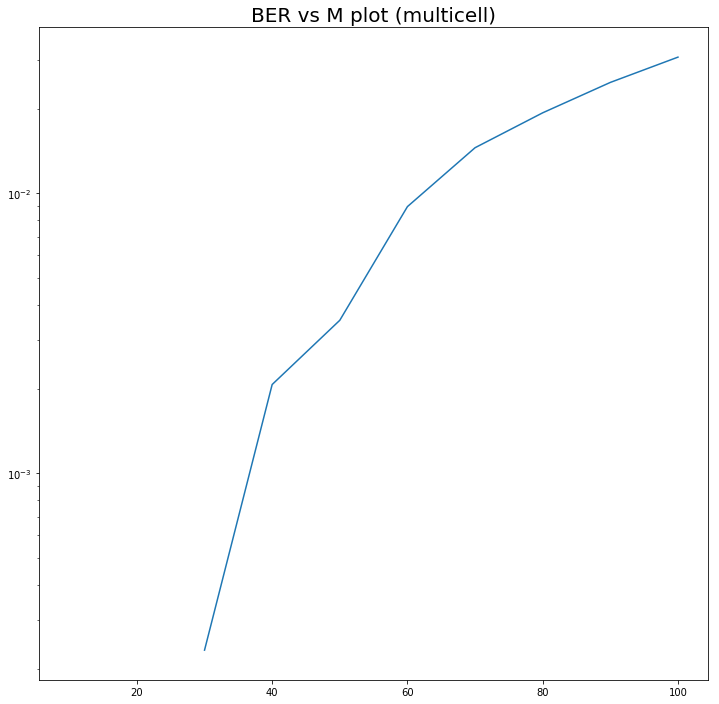

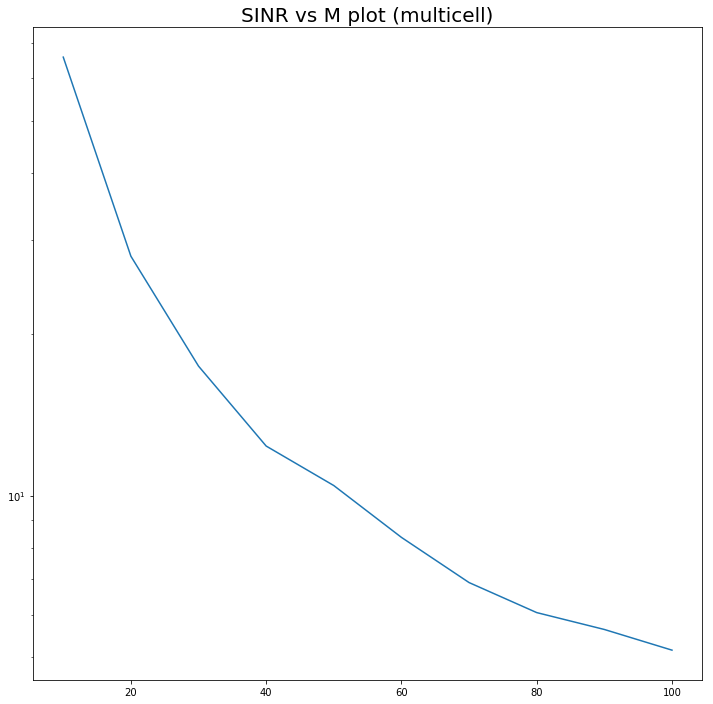

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,Point
import scipy.linalg as la

# Generates random points in the ref_cell poynomial
def random_gen_in_polygon(center):
    # Radius of hexagon cell
    Rc=500
    # Theta corresponding to vertex of hexagon
    theta_list=np.array([0,60,120,180,240,300])*np.pi/180
    #Vertices
    vertices=[(Rc*np.cos(theta),Rc*np.sin(theta)) for theta in theta_list]
    ref_cell = Polygon(vertices)
    x_lim=Rc
    y_lim=Rc
    #While will exit once a point is generated inside the hexagon
    while(True):
        rand_x=2*np.random.rand()*x_lim-x_lim
        rand_y=2*np.random.rand()*y_lim-y_lim
        test_np=np.array([rand_x,rand_y])
        test_pt=Point(rand_x,rand_y)
        #Within function checks whether a point is inside ref_cell or not
        if(test_pt.within(ref_cell)):
            #Also reject points less than 10 m near BS
            if(la.norm(test_pt)>10):
                return (center[0]+rand_x,center[1]+rand_y)

def get_Rxed_pow(pt_in_cell,BS_cords):
    sig_pow_dbm=-60
    sig_pow=0.001*10**(sig_pow_dbm/10)
    d_BS=la.norm([pt_in_cell[0]-BS_cords[0],pt_in_cell[1]-BS_cords[1]])
    d_orig=la.norm([pt_in_cell[0],pt_in_cell[1]])
    gamma=3.5
    rxed_pow=sig_pow*(d_BS/d_orig)**gamma
    return rxed_pow
    
def BER_SINR_vs_M_multicell(M):
    M=int(M)
    sig_pow_dbm=-60
    sig_pow=0.001*10**(sig_pow_dbm/10)
    noise_pow_dbm=-90
    noise_pow=0.001*10**(noise_pow_dbm/10)
    
    #Symbols txed by M MS's
    num_syms=1000
    PRN_len=512
    PRN_seq=2*np.random.randint(2,size=(PRN_len,M))-1
    unknown_PRN_seq=2*np.random.randint(2,size=(PRN_len,6*M))-1
    
    BER=np.zeros(M)
    SINR=np.zeros(M)
    Rc=500
    theta_list=np.array([0,60,120,180,240,300])*np.pi/180
    nbr_interferers=[(3**0.5*Rc*np.cos(theta),3**0.5*Rc*np.sin(theta))\
                     for theta in theta_list]
        
    interfered_pow=np.array([get_Rxed_pow(\
                    random_gen_in_polygon(nbr_interferers[i//M]),nbr_interferers[i//M])\
                   for i in range(6*M)]) 
        
    for t in range(num_syms):
        
        interferer_sym_gen=2*np.random.randint(2,size=(6*M))-1
        interferer_sig_gen=np.sqrt(interfered_pow)*interferer_sym_gen
        interfered_sig=np.sum(np.multiply(interferer_sig_gen,unknown_PRN_seq),axis=1)
        sym_gen=2*np.random.randint(2,size=(M))-1
        sig_gen=np.sqrt(sig_pow)*sym_gen
        Noise_sigma_V=np.sqrt(noise_pow/2)
        # Get Noise
        Noise=(np.random.normal(0,Noise_sigma_V,size=(PRN_len)))
        
        diff_sigs=np.multiply(sig_gen,PRN_seq)
        var_user=np.sum(np.square(diff_sigs),axis=0)/512
        var_interfered=np.sum(np.square(interfered_sig))/512
        sig_rxed=np.sum(diff_sigs,axis=1)+Noise+interfered_sig
        var_sig=np.sum(np.square(sig_rxed))/512
        SINR+=[var_user[i]/(var_sig-var_user[i]+var_interfered) for i in range(M)]
        
        #Multiply by PRN seq again
        dePRN_sig=np.matmul(sig_rxed,PRN_seq)
        
        #Decode by decision region
        bins=[0]
        decoded_sig=2*np.digitize(dePRN_sig.real,bins)-1
        
        #BER: *1 to convert bool to int
        BER+=(decoded_sig!=sym_gen)*1
    
    avg_BER=np.sum(BER)/(M*num_syms)
    avg_SINR=np.sum(SINR)/M
    return avg_BER,avg_SINR

plt.rcParams['figure.figsize'] = (12,12)
sim_M=np.linspace(10,100,10)
BER_SINR_vs_M=[BER_SINR_vs_M_multicell(M) for M in sim_M]
BER_vs_M=[BER_SINR[0] for BER_SINR in BER_SINR_vs_M]
SINR_vs_M=[BER_SINR[1] for BER_SINR in BER_SINR_vs_M]

plt.title("BER vs M plot (multicell)",fontsize=20)
plt.semilogy(sim_M,BER_vs_M)
plt.show()
plt.title("SINR vs M plot (multicell)",fontsize=20)
plt.semilogy(sim_M,SINR_vs_M)
plt.show()

## Plotting both in a single plot

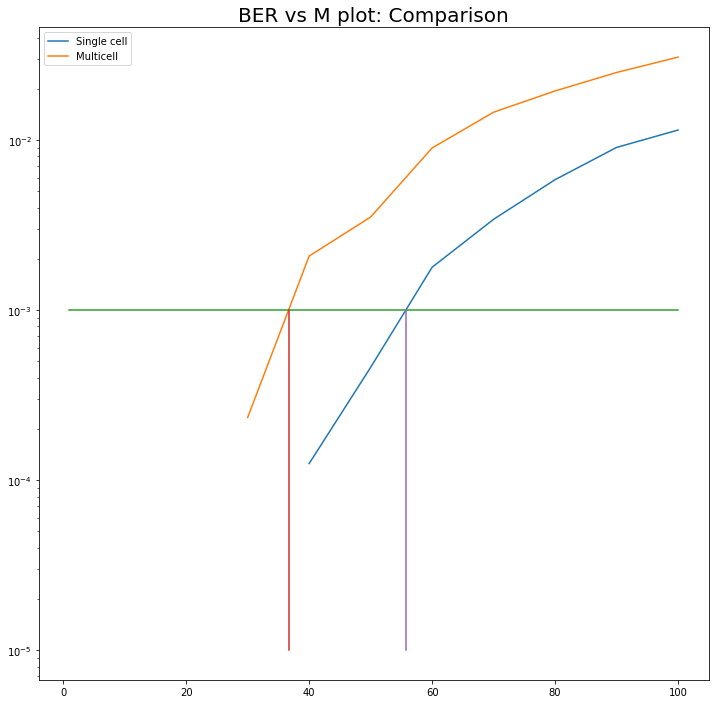

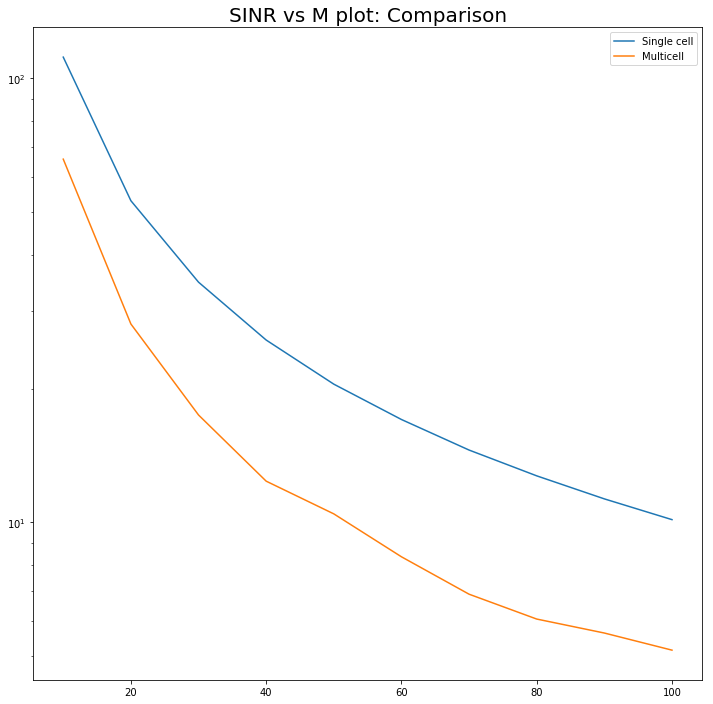

In [33]:
BER_vs_M_multicell=[BER_SINR[0] for BER_SINR in BER_SINR_vs_M]
SINR_vs_M_multicell=[BER_SINR[1] for BER_SINR in BER_SINR_vs_M]
BER_vs_M=[BER_SINR[0] for BER_SINR in BER_SINR_vs_M_singlecell]
SINR_vs_M=[BER_SINR[1] for BER_SINR in BER_SINR_vs_M_singlecell]
plt.title("BER vs M plot: Comparison",fontsize=20)
plt.semilogy(sim_M,BER_vs_M)
plt.semilogy(sim_M,BER_vs_M_multicell)
plt.plot([1,100],[1e-3,1e-3])
plt.plot([36.8,36.8],[1e-5,1e-3])
plt.plot([55.7,55.7],[1e-5,1e-3])
plt.legend(['Single cell','Multicell'])
plt.show()
plt.title("SINR vs M plot: Comparison",fontsize=20)
plt.semilogy(sim_M,SINR_vs_M)
plt.semilogy(sim_M,SINR_vs_M_multicell)
plt.legend(['Single cell','Multicell'])
plt.show()

## Comments

As expected, the performance of the system deteriorates when we go from single cell case to multi cell, viz. the SINR decreases and BER increases.

# CDMA Capacity for $10^{-3}$ BER

* For single cell, we get $10^{-3}$ BER for about 37 users
* For multi cell with one level of interferers, we get $10^{-3}$ BER for 56 users.
* The ratio is approximately 1.51, which is nearby the theoretically expected 1.6, given that we considered only a single level of interferers

---